**https://ods.ai/competitions/mtsmlcup**


В данном блокноте исследую данные, выполняю их предобработку и собираю в единый датасет, сохраняю в файл для последующей работы.\
Сохраняю также промежуточные результаты, так как иногда вылетает из-за нехватки памяти.

# Загрузка библиотек

In [4]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import bisect

# Целевые признаки для обучения

In [63]:
target_train = pd.read_feather('/kaggle/input/mts-ml-cookies/target_train.feather')
target_train.user_id = target_train.user_id.astype('int32')
target_train.head(2)

,age,is_male,user_id
0,31.0,1,350459
1,35.0,1,188276


In [65]:
target_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   age      269970 non-null  float64
 1   is_male  264326 non-null  object 
 2   user_id  270000 non-null  int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 5.1+ MB


In [6]:
target_train.isna().sum()

age          30
is_male    5674
user_id       0
dtype: int64

<AxesSubplot:>

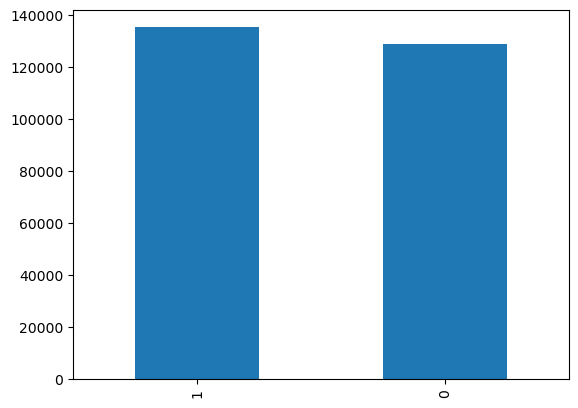

In [7]:
#распределение мужчин и женщин 
target_train.is_male.value_counts().plot.bar()

Кол-во М и Ж в выборке одинаково, это хорошо.

# Submit

In [18]:
id_to_submit = pd.read_feather('/kaggle/input/mts-ml-cookies/submission.feather')
id_to_submit

,user_id
0,221301
1,31271
2,211594
3,253119
4,192578
...,...
144719,415284
144720,415285
144721,415286
144722,415306


# Список посещенных адресов: url_hosts


In [5]:
# прочитаем только id и url_host
url_hosts = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather', columns=['user_id', 'url_host'])
url_hosts

,user_id,url_host
0,45098,ad.adriver.ru
1,45098,apple.com
2,45098,avatars.mds.yandex.net
3,45098,googleads.g.doubleclick.net
4,45098,googleads.g.doubleclick.net
...,...,...
322899430,300964,avatars.mds.yandex.net
322899431,300964,googleads.g.doubleclick.net
322899432,300964,online.sberbank.ru
322899433,300964,s0.2mdn.net


In [89]:
url_hosts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 2 columns):
 #   Column    Dtype   
---  ------    -----   
 0   user_id   int32   
 1   url_host  category
dtypes: category(1), int32(1)
memory usage: 2.4 GB


In [90]:
url_hosts.isnull().sum()

user_id     0
url_host    0
dtype: int64

In [9]:
# всего уникальных адресов
len(url_hosts['url_host'].unique())

199683

In [91]:
# кол-во повторов 
url_hosts['url_host'].value_counts()

googleads.g.doubleclick.net    22013466
yandex.ru                      19007657
i.ytimg.com                    16901446
vk.com                         16695251
avatars.mds.yandex.net         16212095
                                 ...   
money.poprostomu.com                  1
money.irktorgnews.ru                  1
monety-10-50.blogspot.com             1
monetainfo.ru                         1
яркнига24.рф                          1
Name: url_host, Length: 199683, dtype: int64

Некоторые урлы встречаются во всей базе только один раз. Для уменьшения размерности думаю их можно удалить

In [4]:
# список урлов для удаления (которые встречаются только один раз)
urls_for_drop = list(url_hosts['url_host'].value_counts()[url_hosts['url_host'].value_counts() == 1].index)
urls_for_drop[:5]

['uvildy.nuipogoda.ru',
 'spbviking.com',
 'zgros.ru',
 'xn--19-6kcae4bogweffs6a.xn--p1ai',
 'xn---31-5cdk3c0ac6a9h.xn--p1ai']

In [5]:
# исключим эти записи с единичными урлами
url_hosts = url_hosts[~url_hosts.url_host.isin(urls_for_drop)]
url_hosts

,user_id,url_host
0,45098,ad.adriver.ru
1,45098,apple.com
2,45098,avatars.mds.yandex.net
3,45098,googleads.g.doubleclick.net
4,45098,googleads.g.doubleclick.net
...,...,...
322899430,300964,avatars.mds.yandex.net
322899431,300964,googleads.g.doubleclick.net
322899432,300964,online.sberbank.ru
322899433,300964,s0.2mdn.net


In [1]:
#===============технические урлы=============================#

In [5]:
tmp=url_hosts

In [ ]:
tmp.drop(tmp[tmp.url_host.str.contains('mds.')])

In [7]:
del_list = ['ad.', 'googleads.g.doubleclick.net', 'ads.', 'block.mts.ru', 'unblock.mts.ru', \
'blocked.mts.ru', 'mds.', 'banners', 'cdn.']

In [ ]:
#===============технические урлы=============================#

In [6]:
# функция для объединения урлов в одну строку
def join_string(s):
    string=[]
    for i in s:
        i = str(i)
        if i not in string:
            string.append(i)
    return ' '.join(map(str, string))

In [7]:
# сгруппируем по пользователю, применим функцию для объединения урлов и сохраним в отдельную переменную
url_hosts_join = url_hosts[['user_id','url_host']].groupby('user_id') \
                                                  .agg({'url_host': join_string}) 
url_hosts_join.reset_index(inplace=True)
url_hosts_join.user_id = url_hosts_join.user_id.astype('int32')
url_hosts_join

,user_id,url_host
0,0,s0.2mdn.net avatars.mds.yandex.net googleads.g...
1,1,avatars.mds.yandex.net i.ytimg.com ads.between...
2,2,lentaru.media.eagleplatform.com i.ytimg.com no...
3,3,ad.mail.ru avatars.mds.yandex.net mail.yandex....
4,4,kp.md yastatic.net avatars.mds.yandex.net sun9...
...,...,...
415312,415312,googleads.g.doubleclick.net
415313,415313,avatars.mds.yandex.net
415314,415314,vk.com
415315,415315,yandex.ru


In [8]:
url_hosts_join.isnull().sum()

user_id     0
url_host    0
dtype: int64

In [9]:
# сохраню в файл
url_hosts_join.to_csv('url_hosts_join.csv' , index=False)

# Кол-во уникальных адресов для каждого пользователя: uniq_urls_cnt

In [30]:
# прочитаем только id и url_host
user_uniq_urls_cnt = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather', columns=['user_id', 'url_host'])
user_uniq_urls_cnt

,user_id,url_host
0,45098,ad.adriver.ru
1,45098,apple.com
2,45098,avatars.mds.yandex.net
3,45098,googleads.g.doubleclick.net
4,45098,googleads.g.doubleclick.net
...,...,...
322899430,300964,avatars.mds.yandex.net
322899431,300964,googleads.g.doubleclick.net
322899432,300964,online.sberbank.ru
322899433,300964,s0.2mdn.net


In [31]:
# удалим повторящиеся записи, так как нам нужны только уникальные урлы
user_uniq_urls_cnt = user_uniq_urls_cnt.drop_duplicates()
user_uniq_urls_cnt

,user_id,url_host
0,45098,ad.adriver.ru
1,45098,apple.com
2,45098,avatars.mds.yandex.net
3,45098,googleads.g.doubleclick.net
5,45098,i.ytimg.com
...,...,...
322899327,300964,youtube.com
322899331,300964,biosfera.kz
322899339,300964,chihuahuadog-ru.turbopages.org
322899357,300964,sun9-88.userapi.com


In [32]:
# сгруппирую по пользователю и посчитаю кол-во записей
user_uniq_urls_cnt = user_uniq_urls_cnt.groupby('user_id').count() 
user_uniq_urls_cnt.reset_index(inplace=True) 
user_uniq_urls_cnt.rename(columns = {'url_host':'uniq_urls_cnt'}, inplace=True)
user_uniq_urls_cnt.user_id = user_uniq_urls_cnt.user_id.astype('int32')
user_uniq_urls_cnt.uniq_urls_cnt  = user_uniq_urls_cnt.uniq_urls_cnt.astype('int32')
user_uniq_urls_cnt

,user_id,uniq_urls_cnt
0,0,52
1,1,136
2,2,51
3,3,43
4,4,108
...,...,...
415312,415312,1
415313,415313,1
415314,415314,1
415315,415315,1


In [33]:
# сохраню в файл
user_uniq_urls_cnt.to_csv('user_uniq_urls_cnt.csv', index=False)

# Регион пользователя: region_name

In [8]:
# прочитаем только id и region_name
regions = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather', 
                       columns=['user_id', 'region_name'])
regions

,user_id,region_name
0,45098,Краснодарский край
1,45098,Краснодарский край
2,45098,Краснодарский край
3,45098,Краснодарский край
4,45098,Краснодарский край
...,...,...
322899430,300964,Калужская область
322899431,300964,Калужская область
322899432,300964,Калужская область
322899433,300964,Калужская область


In [68]:
regions.value_counts().sort_values()

user_id  region_name          
0        Москва                   1
5        Ленинградская область    1
6        Московская область       1
7        Москва                   1
8        Нижегородская область    1
                                 ..
415269   Ростовская область       1
415270   Белгородская область     1
415271   Хабаровский край         1
415312   Тамбовская область       1
415316   Удмуртская Республика    1
Length: 415317, dtype: int64

In [10]:
# есть записи когда один и тот же пользователь может находится в разных регионах
# сделаю группировку по пользователю и выберу в качестве его региона моду
regions = regions.groupby('user_id').agg(pd.Series.mode)
regions.reset_index(inplace=True)
regions = regions.rename(columns = {'index':'user_id'})
regions.user_id = regions.user_id.astype('int32')
regions

,user_id,region_name
0,0,Москва
1,1,Москва
2,2,Республика Коми
3,3,Воронежская область
4,4,Краснодарский край
...,...,...
415312,415312,Тамбовская область
415313,415313,Саратовская область
415314,415314,Новосибирская область
415315,415315,Краснодарский край


In [11]:
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      415317 non-null  int32 
 1   region_name  415317 non-null  object
dtypes: int32(1), object(1)
memory usage: 4.8+ MB


In [12]:
# сохранение в файл
regions.to_csv('regions.csv', index=False)

# Тип устройства пользователя: cpe_type_cd

In [13]:
cpe_types = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather', 
                       columns=['user_id', 'cpe_type_cd'])
cpe_types

,user_id,cpe_type_cd
0,45098,smartphone
1,45098,smartphone
2,45098,smartphone
3,45098,smartphone
4,45098,smartphone
...,...,...
322899430,300964,smartphone
322899431,300964,smartphone
322899432,300964,smartphone
322899433,300964,smartphone


In [18]:
cpe_types.cpe_type_cd.unique()

['smartphone', 'plain', 'tablet', 'phablet']
Categories (4, object): ['phablet', 'plain', 'smartphone', 'tablet']

Типов устройств всего 4, врядли они помогут в предсказании, пока не будем использовать этот признак.

# Модель устройства пользователя: cpe


In [6]:
cpe_models = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather', 
                       columns=['user_id','cpe_manufacturer_name', 'cpe_model_name'])
cpe_models

,user_id,cpe_manufacturer_name,cpe_model_name
0,45098,Apple,iPhone 7
1,45098,Apple,iPhone 7
2,45098,Apple,iPhone 7
3,45098,Apple,iPhone 7
4,45098,Apple,iPhone 7
...,...,...,...
322899430,300964,Samsung,Galaxy A30s Dual
322899431,300964,Samsung,Galaxy A30s Dual
322899432,300964,Samsung,Galaxy A30s Dual
322899433,300964,Samsung,Galaxy A30s Dual


In [7]:
# удалим дубликаты
cpe_models = cpe_models.drop_duplicates()
cpe_models

,user_id,cpe_manufacturer_name,cpe_model_name
0,45098,Apple,iPhone 7
1550,117132,Xiaomi,Redmi 5 Plus
2272,79395,Samsung,Galaxy S20+
3907,91294,Xiaomi,Poco X3 Pro
5477,161323,Xiaomi,Redmi Note 8 Pro
...,...,...,...
322896216,375972,Apple,iPhone X
322896906,160996,Apple,iPhone 7
322897366,5505,Huawei,P Smart Z
322897462,260127,Apple,iPhone SE 2020


In [8]:
# соединим производителя и модель устройства и сразу удали ненужные признаки
cpe_models['cpe'] = cpe_models[['cpe_manufacturer_name', 'cpe_model_name']].apply(" ".join, axis=1)
cpe_models = cpe_models.drop(columns=['cpe_manufacturer_name', 'cpe_model_name'], axis=1)
cpe_models

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,cpe
0,45098,Apple iPhone 7
1550,117132,Xiaomi Redmi 5 Plus
2272,79395,Samsung Galaxy S20+
3907,91294,Xiaomi Poco X3 Pro
5477,161323,Xiaomi Redmi Note 8 Pro
...,...,...
322896216,375972,Apple iPhone X
322896906,160996,Apple iPhone 7
322897366,5505,Huawei P Smart Z
322897462,260127,Apple iPhone SE 2020


In [55]:
# сохраним файл
cpe_models.to_csv('cpe_models.csv', index=False)

# Активность пользователя по частям дня: part_of_day
В какую часть дня сколько раз пользователь открывал сайты (в какую часть дня пользователь насколько активен)

In [43]:
part_of_day = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather', 
                       columns=['user_id', 'url_host', 'part_of_day'])
part_of_day

,user_id,url_host,part_of_day
0,45098,ad.adriver.ru,morning
1,45098,apple.com,morning
2,45098,avatars.mds.yandex.net,day
3,45098,googleads.g.doubleclick.net,day
4,45098,googleads.g.doubleclick.net,day
...,...,...,...
322899430,300964,avatars.mds.yandex.net,morning
322899431,300964,googleads.g.doubleclick.net,evening
322899432,300964,online.sberbank.ru,day
322899433,300964,s0.2mdn.net,evening


In [44]:
# сгруппирую по пользователю/части суток
part_of_day_cnt = part_of_day.groupby(['user_id', 'part_of_day']).count()
part_of_day_cnt

url_host
user_id part_of_day          
0       day                56
        evening            54
        morning            20
        night               1
1       day               227
...                       ...
415315  night               0
415316  day                 0
        evening             0
        morning             0
        night               1

[1661268 rows x 1 columns]

In [26]:
# переформатирую таличку с помощью pivot
part_of_day_cnt = part_of_day_cnt.pivot_table('url_host', ['user_id'], 'part_of_day')
part_of_day_cnt.reset_index(inplace=True)
part_of_day_cnt

part_of_day,user_id,day,evening,morning,night
0,0,56,54,20,1
1,1,227,202,237,34
2,2,172,106,72,6
3,3,67,75,44,2
4,4,199,170,212,10
...,...,...,...,...,...
415312,415312,1,0,0,0
415313,415313,1,0,0,0
415314,415314,1,0,0,0
415315,415315,1,0,0,0


In [27]:
part_of_day_cnt = part_of_day_cnt.astype('int32')

In [13]:
part_of_day_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415317 entries, 0 to 415316
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  415317 non-null  int32
 1   day      415317 non-null  int32
 2   evening  415317 non-null  int32
 3   morning  415317 non-null  int32
 4   night    415317 non-null  int32
dtypes: int32(5)
memory usage: 7.9 MB


In [14]:
# сохранение
part_of_day_cnt.to_csv('part_of_day_cnt.csv', index=False)

# Активность пользователя по дням недели: weekday

In [76]:
weekday = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather', 
                       columns=['user_id', 'date'])
weekday.head(2)

,user_id,date
0,45098,2022-06-15
1,45098,2022-06-19


In [77]:
weekday['weekday'] = weekday.date.dt.dayofweek
weekday.head(2)

,user_id,date,weekday
0,45098,2022-06-15,2
1,45098,2022-06-19,6


In [ ]:
# сгруппирую по пользователю/дню недели
weekday = weekday.groupby(['user_id', 'weekday']).count()
weekday

In [23]:
# переформатирую таличку с помощью pivot
weekday = weekday.pivot_table('date', ['user_id'], 'weekday')
weekday

weekday,0,1,2,3,4,5,6
user_id,,,,,,,
0,4.0,43.0,36.0,5.0,9.0,23.0,11.0
1,118.0,99.0,151.0,90.0,93.0,77.0,72.0
2,44.0,48.0,66.0,42.0,55.0,46.0,55.0
3,28.0,17.0,28.0,26.0,48.0,14.0,27.0
4,92.0,38.0,62.0,73.0,112.0,114.0,100.0
...,...,...,...,...,...,...,...
415312,NaN,NaN,NaN,1.0,NaN,NaN,NaN
415313,NaN,NaN,NaN,NaN,NaN,1.0,NaN
415314,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
weekday.reset_index(inplace=True)
weekday.fillna(0, inplace=True)
weekday = weekday.astype('int32')

In [29]:
weekday

weekday,user_id,0,1,2,3,4,5,6
0,0,4,43,36,5,9,23,11
1,1,118,99,151,90,93,77,72
2,2,44,48,66,42,55,46,55
3,3,28,17,28,26,48,14,27
4,4,92,38,62,73,112,114,100
...,...,...,...,...,...,...,...,...
415312,415312,0,0,0,1,0,0,0
415313,415313,0,0,0,0,0,1,0
415314,415314,1,0,0,0,0,0,0
415315,415315,0,0,0,0,0,0,1


In [31]:
weekday.to_csv('weekday.csv', index=False)

# ===================================================================

# Объединение в один большой датасет

In [126]:
url_hosts_join = pd.read_csv('/kaggle/input/url-hosts-join/url_hosts_join.csv')
user_uniq_urls_cnt = pd.read_csv('/kaggle/input/url-hosts-join/user_uniq_urls_cnt.csv')
regions = pd.read_csv('/kaggle/input/url-hosts-join/regions.csv')
cpe_models = pd.read_csv('/kaggle/input/url-hosts-join/cpe_models.csv')
part_of_day_cnt = pd.read_csv('/kaggle/input/url-hosts-join/part_of_day_cnt.csv')
weekday = pd.read_csv('/kaggle/working/weekday.csv')

In [127]:
data = url_hosts_join.merge(user_uniq_urls_cnt, how='inner')
data = data.merge(regions, how='inner')
data = data.merge(cpe_models, how='inner')
data = data.merge(part_of_day_cnt, how='inner')
data = data.merge(weekday, how='inner')

In [128]:
data

,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,0,1,2,3,4,5,6
0,0,s0.2mdn.net avatars.mds.yandex.net googleads.g...,52,Москва,Samsung Galaxy J1 2016 LTE Dual,56,54,20,1,4,43,36,5,9,23,11
1,1,avatars.mds.yandex.net i.ytimg.com ads.between...,136,Москва,Xiaomi Mi 9,227,202,237,34,118,99,151,90,93,77,72
2,2,lentaru.media.eagleplatform.com i.ytimg.com no...,51,Республика Коми,Huawei Honor 9 Lite,172,106,72,6,44,48,66,42,55,46,55
3,3,ad.mail.ru avatars.mds.yandex.net mail.yandex....,43,Воронежская область,Huawei Device Company Limited P Smart 2021,67,75,44,2,28,17,28,26,48,14,27
4,4,kp.md yastatic.net avatars.mds.yandex.net sun9...,108,Краснодарский край,Huawei Nova 3,199,170,212,10,92,38,62,73,112,114,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415312,415312,googleads.g.doubleclick.net,1,Тамбовская область,Huawei Honor 7S Dual,1,0,0,0,0,0,0,1,0,0,0
415313,415313,avatars.mds.yandex.net,1,Саратовская область,Xiaomi Redmi 6A,1,0,0,0,0,0,0,0,0,1,0
415314,415314,vk.com,1,Новосибирская область,Huawei Device Company Limited Honor 10X Lite,1,0,0,0,1,0,0,0,0,0,0
415315,415315,yandex.ru,1,Краснодарский край,Huawei Honor 7S Dual,1,0,0,0,0,0,0,0,0,0,1


In [47]:
data.isna().sum()

user_id          0
url_host         1
uniq_urls_cnt    0
region_name      0
cpe              0
day              0
evening          0
morning          0
night            0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
dtype: int64

In [48]:
# закрался один пропуск, заменим на что-нибудь
data[data.url_host.isna()]

,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,0,1,2,3,4,5,6
284102,284102,NaN,1,Краснодарский край,Huawei Honor 10,0,1,0,0,0,0,0,1,0,0,0


In [49]:
data.loc[284102, 'url_host'] = 'Not'

In [51]:
data.isna().sum()

user_id          0
url_host         0
uniq_urls_cnt    0
region_name      0
cpe              0
day              0
evening          0
morning          0
night            0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
dtype: int64

In [52]:
#сохраним в файл
data.to_csv('data.csv', index=False)

# ===================================================================

# Визуалиции

## Кол-во уникальных адресов

In [180]:
# объединим с данными по полу/возрасту
db1 = pd.DataFrame(data[['user_id', 'uniq_urls_cnt']].merge(target_train, how='inner'))
db1.head(2)

,user_id,uniq_urls_cnt,age,is_male
0,0,52,35.0,0
1,1,136,41.0,0


In [181]:
# сгруппирую по полу/возрасту и выведу статистики
db2 = db1.groupby(['is_male', 'age']).uniq_urls_cnt.describe().reset_index()
db2

,is_male,age,count,mean,std,min,25%,50%,75%,max
0,0,14.0,3.0,30.666667,30.072135,9.0,13.50,18.0,41.50,65.0
1,0,15.0,5.0,100.600000,90.403540,4.0,46.00,81.0,134.00,238.0
2,0,16.0,29.0,93.344828,71.491896,5.0,44.00,85.0,125.00,264.0
3,0,17.0,37.0,97.135135,58.048429,2.0,55.00,89.0,144.00,224.0
4,0,18.0,292.0,82.571918,57.630816,1.0,43.00,72.5,108.25,368.0
...,...,...,...,...,...,...,...,...,...,...
143,1,83.0,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0
144,1,84.0,4.0,117.000000,111.304387,5.0,32.75,112.5,196.75,238.0
145,1,85.0,2.0,76.500000,106.773124,1.0,38.75,76.5,114.25,152.0
146,1,86.0,1.0,102.000000,NaN,102.0,102.00,102.0,102.00,102.0


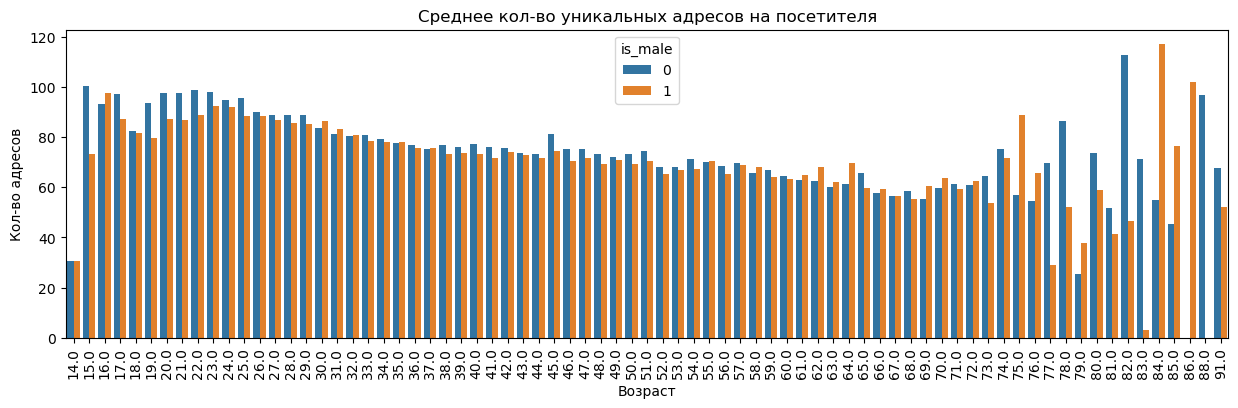

In [205]:
# возьмем среднее кол-во урлов на посетителя и посмотрим его распределение в зависимости от пола/возраста
plt.figure(figsize=(15,4))
plt.xticks(rotation=90)
sns.barplot(db2, x='age', y='mean',  hue='is_male').set(xlabel='Возраст', ylabel='Кол-во адресов', title='Cреднее кол-во уникальных адресов на посетителя')
plt.show()

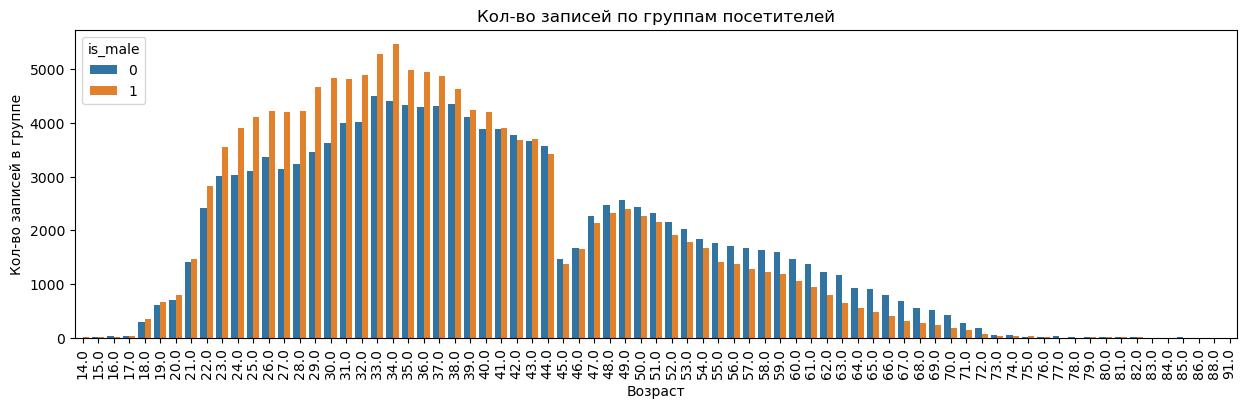

In [207]:
# возьмем кол-во записей на каждую группу и посмотрим его распределение в зависимости от пола/возраста
plt.figure(figsize=(15,4))
plt.xticks(rotation=90)
sns.barplot(db2, x='age', y='count',  hue='is_male').set(xlabel='Возраст', ylabel='Кол-во записей в группе', title='Кол-во записей по группам посетителей')
plt.show()

Видим, что после возраста 70+ идут какие-то всплески по кол-ву адресов, при этом это самая малочисленная группа. \
Можно попробовать удалить этот хвост при обучении, возможно это улучшит метрики.

<AxesSubplot:>

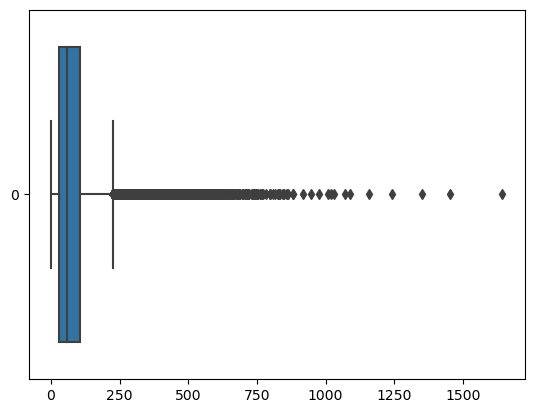

In [215]:
# Посмотрим на выбросы по кол-ву уникальных адресов на посетителя
sns.boxplot(db1.uniq_urls_cnt, orient='h')

<AxesSubplot:xlabel='uniq_urls_cnt', ylabel='Count'>

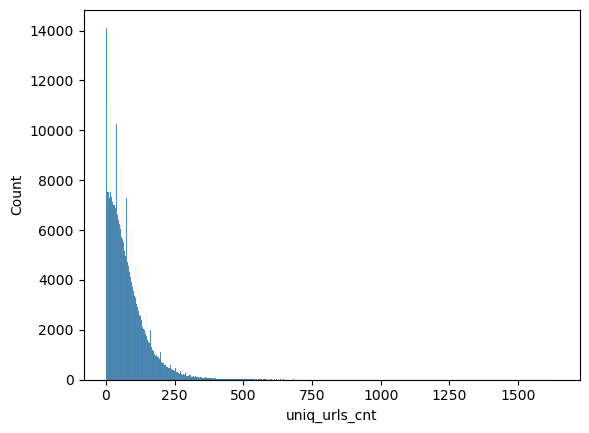

In [209]:
sns.histplot(data.uniq_urls_cnt)

Видим очень длинный хвост справа. У абсолютного большинства посетителей кол-во уникальных адресов до 250...500. Всё, что находится правее можно отсечь

In [217]:
# индексы записей с выбросами по кол-ву уникальных урлов на пользователя
id_outliers_ = pd.DataFrame(data[user_uniq_urls_cnt.uniq_urls_cnt>500].user_id)
id_outliers_.head(2)

,user_id
43,43
797,797


In [220]:
# важный момент: не удалить из данных те записи, которые встречаются в сабмите
# оставим только непересекающиеся с ним записи
id_outliers = id_outliers_[~id_outliers_.user_id.isin(id_to_submit.user_id)]
id_outliers.head(2)

,user_id
797,797
1090,1090


## Активность пользователей в зависимости от части 

In [223]:
db3 = pd.DataFrame(data[['user_id', 'day', 'evening', 'morning', 'night']].merge(target_train, how='inner'))
db3.head(2)

,user_id,day,evening,morning,night,age,is_male
0,0,56,54,20,1,35.0,0
1,1,227,202,237,34,41.0,0


In [248]:
db4 = db3.melt(id_vars=["user_id", "age", "is_male"], var_name="part_of_day", value_name="part_of_day_cnt")
db4

,user_id,age,is_male,part_of_day,part_of_day_cnt
0,0,35.0,0,day,56
1,1,41.0,0,day,227
2,2,25.0,0,day,172
3,3,50.0,1,day,67
4,4,28.0,0,day,199
...,...,...,...,...,...
1079995,415308,49.0,None,night,0
1079996,415309,31.0,0,night,0
1079997,415311,39.0,0,night,0
1079998,415312,44.0,1,night,0


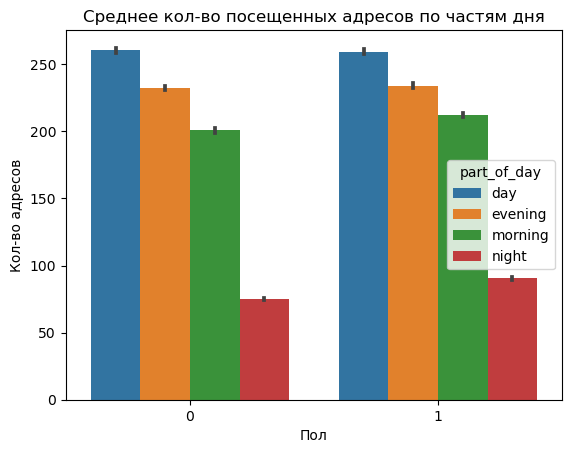

In [254]:
# распределение средней активности пользователей в зависимости от пола и части суток
sns.barplot(data=db4, x='is_male', y='part_of_day_cnt', hue='part_of_day'). \
            set(xlabel='Пол', ylabel='Кол-во адресов', title='Cреднее кол-во посещенных адресов по частям дня')
plt.show()

Самая активная часть суток - день.

In [267]:
db5 = pd.DataFrame(db4.groupby(['age', 'part_of_day']).mean()).reset_index()

In [268]:
db5

,age,part_of_day,user_id,part_of_day_cnt
0,14.0,day,239939.714286,115.000000
1,14.0,evening,239939.714286,120.357143
2,14.0,morning,239939.714286,85.000000
3,14.0,night,239939.714286,26.142857
4,15.0,day,214749.169811,231.000000
...,...,...,...,...
295,88.0,night,358590.000000,11.000000
296,91.0,day,176310.666667,49.666667
297,91.0,evening,176310.666667,64.666667
298,91.0,morning,176310.666667,34.000000


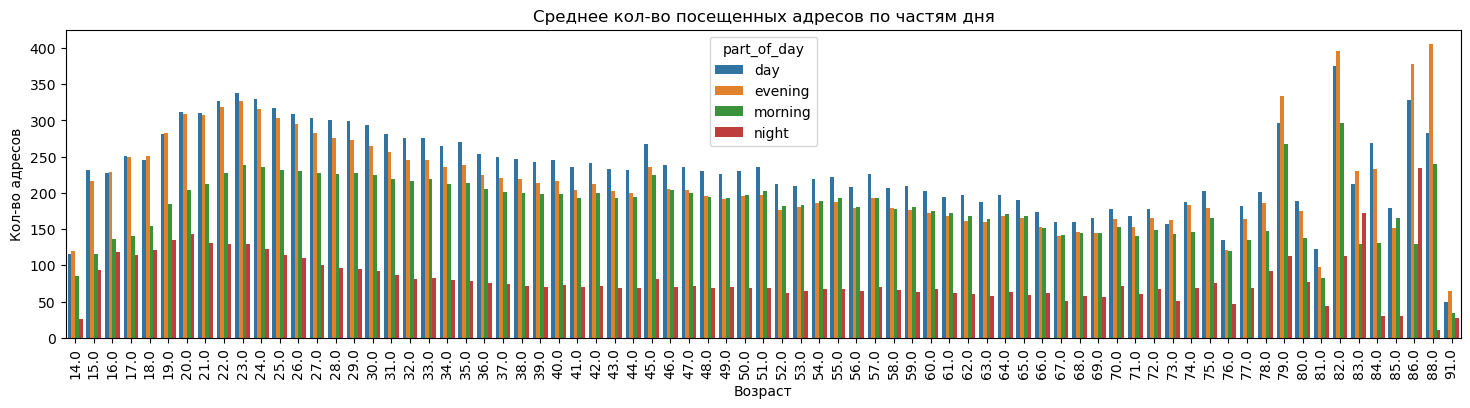

In [269]:
# распределение средней активности пользователей в зависимости от возраста и части суток
plt.figure(figsize=(18,4))
plt.xticks(rotation=90)
sns.barplot(data=db5, x='age', y='part_of_day_cnt', hue='part_of_day'). \
            set(xlabel='Возраст', ylabel='Кол-во адресов', title='Cреднее кол-во посещенных адресов по частям дня')
plt.show()

## Активность пользователей по дням недели

In [271]:
db6 = pd.DataFrame(data[['user_id', '0', '1', '2', '3', '4', '5', '6']].merge(target_train, how='inner'))
db6.head(2)

,user_id,0,1,2,3,4,5,6,age,is_male
0,0,4,43,36,5,9,23,11,35.0,0
1,1,118,99,151,90,93,77,72,41.0,0


In [272]:
db7 = db6.melt(id_vars=["user_id", "age", "is_male"], var_name="weekday", value_name="weekday_cnt")
db7

,user_id,age,is_male,weekday,weekday_cnt
0,0,35.0,0,0,4
1,1,41.0,0,0,118
2,2,25.0,0,0,44
3,3,50.0,1,0,28
4,4,28.0,0,0,92
...,...,...,...,...,...
1889995,415308,49.0,None,6,0
1889996,415309,31.0,0,6,0
1889997,415311,39.0,0,6,0
1889998,415312,44.0,1,6,0


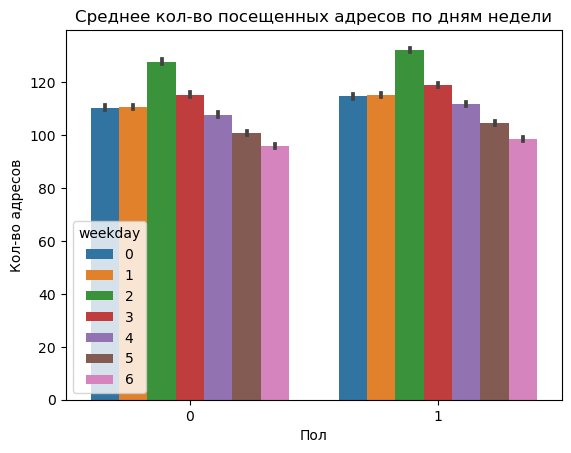

In [273]:
# распределение средней активности пользователей в зависимости от пола и дня недели
sns.barplot(data=db7, x='is_male', y='weekday_cnt', hue='weekday'). \
            set(xlabel='Пол', ylabel='Кол-во адресов', title='Cреднее кол-во посещенных адресов по дням недели')
plt.show()

Наиболее активный день - среда, наименее - воскресенье

In [276]:
db8 = pd.DataFrame(db7.groupby(['age', 'weekday']).mean()).reset_index()
db8.head(2)

,age,weekday,user_id,weekday_cnt
0,14.0,0,239939.714286,46.428571
1,14.0,1,239939.714286,41.214286


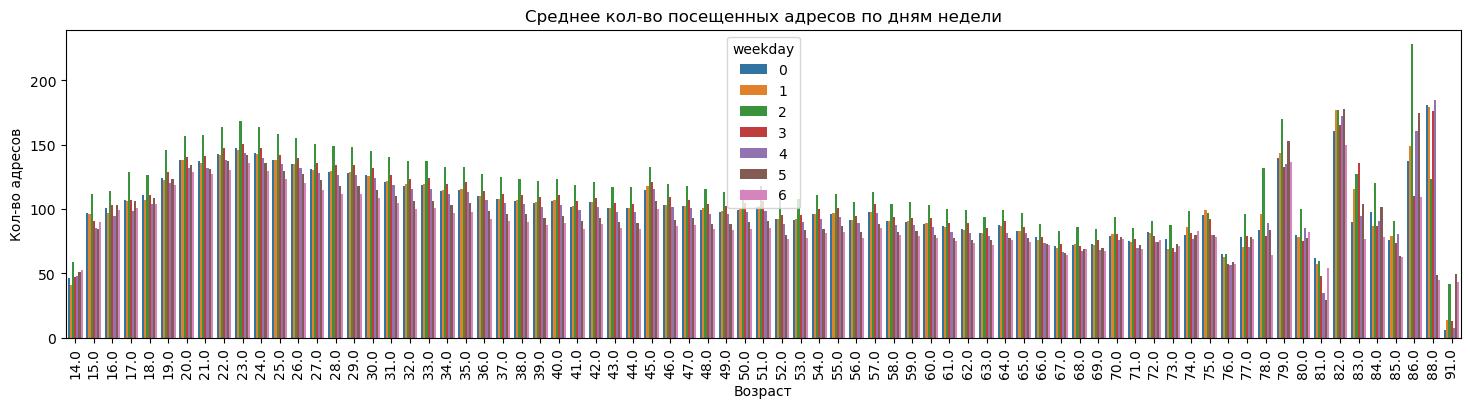

In [277]:
# распределение средней активности пользователей в зависимости от возраста и части суток
plt.figure(figsize=(18,4))
plt.xticks(rotation=90)
sns.barplot(data=db8, x='age', y='weekday_cnt', hue='weekday'). \
            set(xlabel='Возраст', ylabel='Кол-во адресов', title='Cреднее кол-во посещенных адресов по дням недели')
plt.show()

# ===================================================================

# Версия без выбросов

Версию датасета без записей пользователей с выбросами по кол-ву урлов.\
Он используется далее в обучении, так как показал лучшие результаты по сравнению с полной версией.\
Также в обучении отсекается датасет по возрасту - это улучшило результат.


In [112]:
data = pd.read_csv('/kaggle/input/url-hosts-join/data.csv')
data

,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night
0,0,s0.2mdn.net avatars.mds.yandex.net googleads.g...,131,Москва,Samsung Galaxy J1 2016 LTE Dual,56,54,20,1
1,1,avatars.mds.yandex.net i.ytimg.com ads.between...,700,Москва,Xiaomi Mi 9,227,202,237,34
2,2,lentaru.media.eagleplatform.com i.ytimg.com no...,356,Республика Коми,Huawei Honor 9 Lite,172,106,72,6
3,3,ad.mail.ru avatars.mds.yandex.net mail.yandex....,188,Воронежская область,Huawei Device Company Limited P Smart 2021,67,75,44,2
4,4,kp.md yastatic.net avatars.mds.yandex.net sun9...,591,Краснодарский край,Huawei Nova 3,199,170,212,10
...,...,...,...,...,...,...,...,...,...
415312,415312,googleads.g.doubleclick.net,1,Тамбовская область,Huawei Honor 7S Dual,1,0,0,0
415313,415313,avatars.mds.yandex.net,1,Саратовская область,Xiaomi Redmi 6A,1,0,0,0
415314,415314,vk.com,1,Новосибирская область,Huawei Device Company Limited Honor 10X Lite,1,0,0,0
415315,415315,yandex.ru,1,Краснодарский край,Huawei Honor 7S Dual,1,0,0,0


In [140]:
# удалим записи, соответсвующие индексам из idx_outliers
data_clear = data[~data.user_id.isin(id_outliers.user_id)]
data_clear

,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,0,1,2,3,4,5,6
0,0,s0.2mdn.net avatars.mds.yandex.net googleads.g...,52,Москва,Samsung Galaxy J1 2016 LTE Dual,56,54,20,1,4,43,36,5,9,23,11
1,1,avatars.mds.yandex.net i.ytimg.com ads.between...,136,Москва,Xiaomi Mi 9,227,202,237,34,118,99,151,90,93,77,72
2,2,lentaru.media.eagleplatform.com i.ytimg.com no...,51,Республика Коми,Huawei Honor 9 Lite,172,106,72,6,44,48,66,42,55,46,55
3,3,ad.mail.ru avatars.mds.yandex.net mail.yandex....,43,Воронежская область,Huawei Device Company Limited P Smart 2021,67,75,44,2,28,17,28,26,48,14,27
4,4,kp.md yastatic.net avatars.mds.yandex.net sun9...,108,Краснодарский край,Huawei Nova 3,199,170,212,10,92,38,62,73,112,114,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415312,415312,googleads.g.doubleclick.net,1,Тамбовская область,Huawei Honor 7S Dual,1,0,0,0,0,0,0,1,0,0,0
415313,415313,avatars.mds.yandex.net,1,Саратовская область,Xiaomi Redmi 6A,1,0,0,0,0,0,0,0,0,1,0
415314,415314,vk.com,1,Новосибирская область,Huawei Device Company Limited Honor 10X Lite,1,0,0,0,1,0,0,0,0,0,0
415315,415315,yandex.ru,1,Краснодарский край,Huawei Honor 7S Dual,1,0,0,0,0,0,0,0,0,0,1


In [62]:
data_clear.isna().sum()

user_id          0
url_host         0
uniq_urls_cnt    0
region_name      0
cpe              0
day              0
evening          0
morning          0
night            0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
dtype: int64

In [63]:
#сохраним в файл
data_clear.to_csv('data_clear.csv', index=False)

In [64]:
# просто для проверки
id_to_submit.merge(data_clear, how="left", on='user_id').isna().sum()

user_id          0
url_host         0
uniq_urls_cnt    0
region_name      0
cpe              0
day              0
evening          0
morning          0
night            0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
dtype: int64